## Importar

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.applications.vgg16 import preprocess_input

In [3]:
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Features

In [5]:
image_dir = 'Images'

features = {}

for img_name in os.listdir(image_dir):
    filename = os.path.join(image_dir, img_name)
    
    # Cargar y procesar imagen
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    # Extraer características
    feature = model.predict(image, verbose=0)
    img_id = img_name.split('.')[0]  # ejemplo: '123456' de '123456.jpg'
    features[img_id] = feature.flatten()


In [7]:
import pickle
with open("features.pkl", "wb") as f:
    pickle.dump(features, f)

## Captions

In [ ]:
caption_path = 'captions.txt'
descriptions = {}

with open(caption_path, 'r') as file:
    next(file)  # Saltar encabezado
    for line in file:
        tokens = line.strip().split(',')
        img_id, caption = tokens[0], tokens[1]
        img_id = img_id.split('.')[0]
        if img_id not in descriptions:
            descriptions[img_id] = []
        # Puedes agregar tokens especiales para entrenar el modelo
        descriptions[img_id].append('startseq ' + caption + ' endseq')

In [4]:
import string

def clean_captions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, caps in descriptions.items():
        new_caps = []
        for caption in caps:
            caption = caption.lower()
            caption = caption.translate(table)
            caption = caption.split()
            caption = [word for word in caption if len(word) > 1 and word.isalpha()]
            new_caps.append(' '.join(caption))
        descriptions[key] = new_caps

clean_captions(descriptions)

In [ ]:
import pickle

with open("descriptions.pkl", "wb") as f:
    pickle.dump(descriptions, f)

## Tokenizer

In [5]:
from keras.preprocessing.text import Tokenizer

# Crear lista de todas las descripciones
all_captions = []
for key in descriptions:
    all_captions.extend(descriptions[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Guardar tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

## Cargar modelos

In [3]:
import pickle

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Cargar features
with open("features.pkl", "rb") as f:
    features = pickle.load(f)

# Cargar descripciones
with open("descriptions.pkl", "rb") as f:
    descriptions = pickle.load(f)
  

In [4]:
def max_length(descriptions):
    return max(len(caption.split()) for desc in descriptions.values() for caption in desc)

max_len = max_length(descriptions)
max_len

34

In [5]:
vocab_size = len(tokenizer.word_index) + 1

def max_length(descriptions):
    return max(len(d.split()) for desc in descriptions.values() for d in desc)

max_len = max_length(descriptions)
print("Vocab size:", vocab_size)
print("Max caption length:", max_len)

Vocab size: 8574
Max caption length: 34


In [6]:
from tensorflow.keras.utils import pad_sequences, to_categorical
import numpy as np

def data_generator(descriptions, features, tokenizer, max_len, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key])
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1
                    if n == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))
                        X1, X2, y = [], [], []
                        n = 0


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Imagen
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Texto
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Fusionar
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 256)              2194944   ['input_3[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 4096)                 0         ['input_2[0][0]']             
                                                                                              

## Train Model

In [ ]:
epochs=20

In [ ]:
#Forma eficiente
batch_size = 64
steps = sum(len(c) for c in descriptions.values()) // batch_size

generator = data_generator(descriptions, features, tokenizer, max_len, batch_size)

model.fit(generator, epochs=20, steps_per_epoch=steps, verbose=1)
# Guardar el modelo entrenado

model.save("caption_model.h5")

In [8]:
#Forma video
epochs = 20
batch_size = 64

steps = sum(len(c) for c in descriptions.values()) // batch_size

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    generator = data_generator(descriptions, features, tokenizer, max_len, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
# Guardar el modelo entrenado
model.save("caption_model_video.h5")

Epoch 1/20
632/632 [==============================] - 82s 125ms/step - loss: 5.6444
Epoch 2/20
632/632 [==============================] - 75s 118ms/step - loss: 4.6025
Epoch 3/20
632/632 [==============================] - 74s 117ms/step - loss: 4.1776
Epoch 4/20
632/632 [==============================] - 77s 122ms/step - loss: 3.8611
Epoch 5/20
632/632 [==============================] - 75s 119ms/step - loss: 3.6356
Epoch 6/20
632/632 [==============================] - 79s 125ms/step - loss: 3.4421
Epoch 7/20
632/632 [==============================] - 78s 123ms/step - loss: 3.2600
Epoch 8/20
632/632 [==============================] - 81s 128ms/step - loss: 3.1015
Epoch 9/20
632/632 [==============================] - 80s 126ms/step - loss: 2.9433
Epoch 10/20
632/632 [==============================] - 81s 129ms/step - loss: 2.8039
Epoch 11/20
632/632 [==============================] - 86s 136ms/step - loss: 2.6722
Epoch 12/20
632/632 [==============================] - 93s 148ms/step - lo

c:\Users\WD\.conda\envs\tf_gpu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, tokenizer, photo, max_len):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

In [10]:
img_id = '1000268201_693b08cb0e' 
photo = features[img_id]
photo = photo.reshape((1, 4096))

caption = generate_caption(model, tokenizer, photo, max_len=34)  # usa el max_len que calculaste antes
print("Predicción:", caption)

Predicción: little girl climbing into wooden building


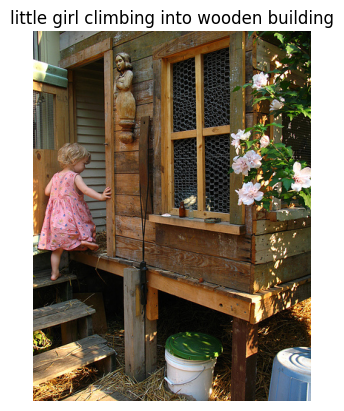

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta a la imagen original
image_path = f"Images/{img_id}.jpg"

# Mostrar imagen + caption
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title(caption)
plt.show()